# K2c02 YSO Summary Statistics *Clean*
##  Calculate the summary statistics for all 1678 YSO K2 C2 lightcurves, but in a restricted range of time to avoid instrumental artifacts
Michael Gully-Santiago  
January-February 2016

There are 1678 light curve files for sources that were proposed for by Kraus, Hillenbrand, Covey, or (?) to be YSOs or YSO candidates in K2 Cycle 2.  See my other notebook for how I downloaded them.  

Once we have the files it's a matter of what to do with them.  Here we read in each file and construct the basic summary statistics using the pandas `describe()` function.  We then save that series and some metadata into a data frame for each lightcurve.  

**The result is a $1658 \times 12 $ dataset of summary statistics for each K2 C2 lightcurve.**  
We had to drop 20 lightcurves that had NaN's for some reason.

Finally, we construct some plots of the new data just to explore it.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina' 
from astropy.utils.console import ProgressBar
import warnings

### Make a list of all the lightcurve filenames.
There's a wget script in the `data` directory that will automatically fetch each file.

```python
!ls ../data/hl* > file_list.csv
```

In [2]:
file_list_raw = pd.read_csv('file_list.csv', names=['fname'])
file_list = file_list_raw.fname.values

### Compute the descriptive statistics for all 1678 of the YSO lightcurves from K2 Cycle 02.  

In [3]:
columns = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
agg_data = pd.DataFrame(columns=columns)

n_files = len(file_list)

### Clean the signal by taking only a subset of the lightcurve.

There's a big discontinuous jump in many of the light curves, close to the middle.  I think it's due to the spacecraft momentum dumps.  
We should just keep the first half for now.

In [4]:
file = file_list[5]
raw_lc = pd.read_csv(file, index_col=False)

In [5]:
subset_i = (raw_lc['BJD - 2454833'] > 2063.0) & (raw_lc['BJD - 2454833'] < 2102.0)

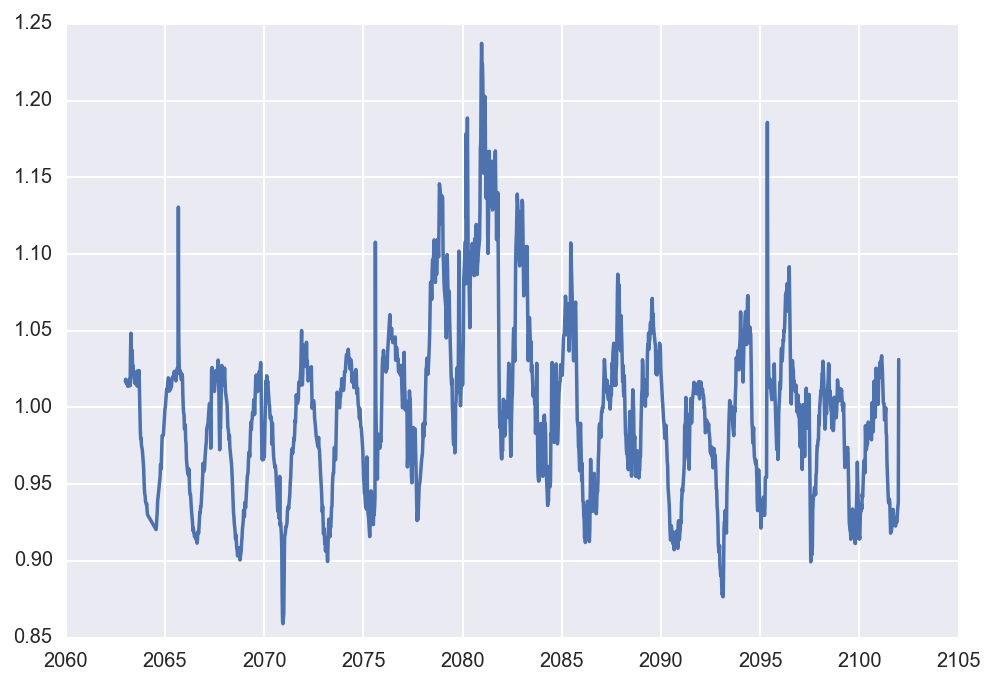

In [20]:
plt.plot(raw_lc['BJD - 2454833'][subset_i], raw_lc[' Corrected Flux'][subset_i])

This takes about 1-2 minutes:

In [7]:
with ProgressBar(n_files, ipython_widget=True) as bar:
    for i in range(n_files):
        bar.update()
        file = file_list[i]
        raw_lc = pd.read_csv(file, index_col=False)
        #subset_i = (raw_lc['BJD - 2454833'] > 2063.0) & (raw_lc['BJD - 2454833'] < 2102.0)
        agg_data.loc[i] = raw_lc[' Corrected Flux'].describe()

In [8]:
cln_data = pd.DataFrame(columns=columns)

In [9]:
with ProgressBar(n_files, ipython_widget=True) as bar:
    for i in range(n_files):
        bar.update()
        file = file_list[i]
        raw_lc = pd.read_csv(file, index_col=False)
        subset_i = (raw_lc['BJD - 2454833'] > 2063.0) & (raw_lc['BJD - 2454833'] < 2102.0)
        cln_data.loc[i] = raw_lc[' Corrected Flux'][subset_i].describe()

Voilà:

In [21]:
agg_data['fname'] = file_list_raw.fname
agg_data['EPIC_ID'] = agg_data['fname'].str[33:33+9]
agg_data.head(3)

,count,mean,std,min,25%,50%,75%,max,fname,EPIC_ID,logstd,logiqr
0,3273,0.989996,0.016853,0.951854,0.974293,0.997179,1.004053,1.100647,../data/hlsp_k2sff_k2_lightcurve_202515599-c02...,202515599,-1.773329,-1.526372
1,3252,1.004516,0.017012,0.961301,0.991919,1.004448,1.015255,1.150416,../data/hlsp_k2sff_k2_lightcurve_202521690-c02...,202521690,-1.769238,-1.631966
2,3318,0.996250,0.013357,0.958312,0.987292,0.995440,1.006136,1.124357,../data/hlsp_k2sff_k2_lightcurve_202533810-c02...,202533810,-1.874303,-1.724841


In [22]:
cln_data['fname'] = file_list_raw.fname
cln_data['EPIC_ID'] = cln_data['fname'].str[33:33+9]
cln_data.head(3)

,count,mean,std,min,25%,50%,75%,max,fname,EPIC_ID,logstd,logiqr
0,1665,1.003428,0.005730,0.991227,0.999249,1.003116,1.006830,1.100647,../data/hlsp_k2sff_k2_lightcurve_202515599-c02...,202515599,-2.241871,-2.120255
1,1644,0.997672,0.015680,0.961301,0.986621,0.996654,1.008163,1.150416,../data/hlsp_k2sff_k2_lightcurve_202521690-c02...,202521690,-1.804656,-1.666728
2,1685,0.989752,0.010231,0.961885,0.982785,0.990425,0.996125,1.016734,../data/hlsp_k2sff_k2_lightcurve_202533810-c02...,202533810,-1.990065,-1.874845


Take the log of the std and IQR.

In [14]:
agg_data['logstd'] = np.log10(agg_data['std'])
agg_data['logiqr'] = np.log10(agg_data['75%']-agg_data['25%'])

In [13]:
cln_data['logstd'] = np.log10(cln_data['std'])
cln_data['logiqr'] = np.log10(cln_data['75%']-cln_data['25%'])

Save the cleaned data.

In [15]:
new_col_order = ['EPIC_ID','count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'logstd', 'logiqr','fname']

In [16]:
cln_out = cln_data[new_col_order]

In [19]:
#cln_out.head()

In [18]:
cln_out.to_csv('../analysis/K2C02_YSO_cln_data.csv', index=False)

### Plot the standard deviation $\sigma$ of the light curve versus its interquartile range ($Q_3-Q_1$).

HACK TO Visualize the cleaned up data!

In [37]:
#agg_data = cln_data

//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


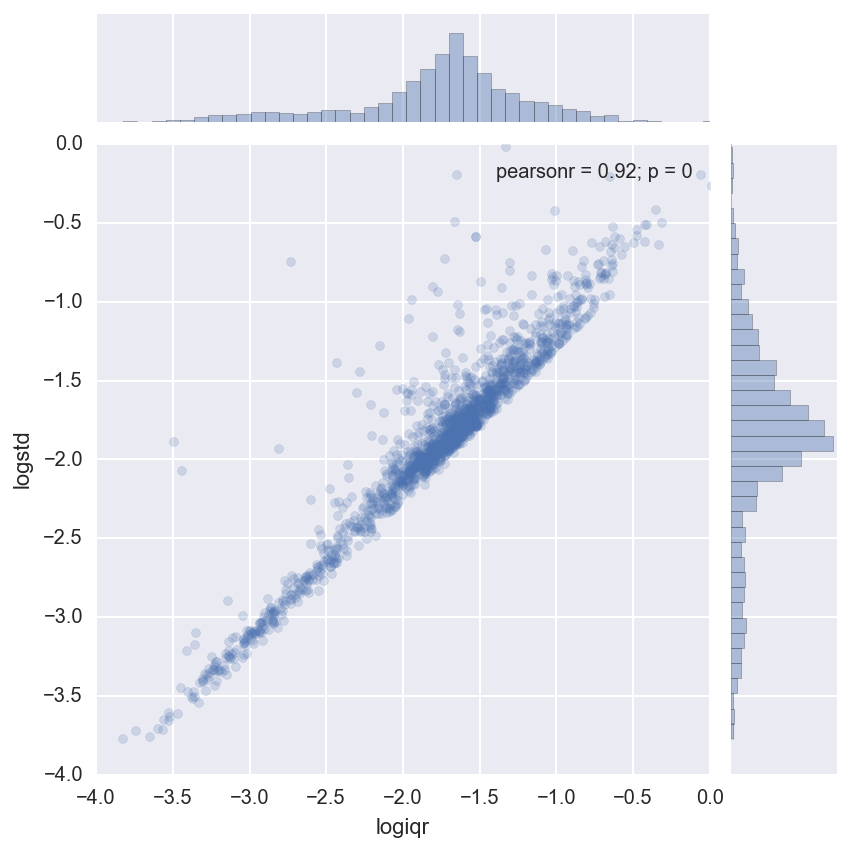

In [24]:
tp = sns.jointplot(x="logiqr", y="logstd", alpha=0.2, kind='scatter',data=agg_data, xlim=(-4, 0), ylim=(-4, 0));

In [25]:
import bokeh

//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


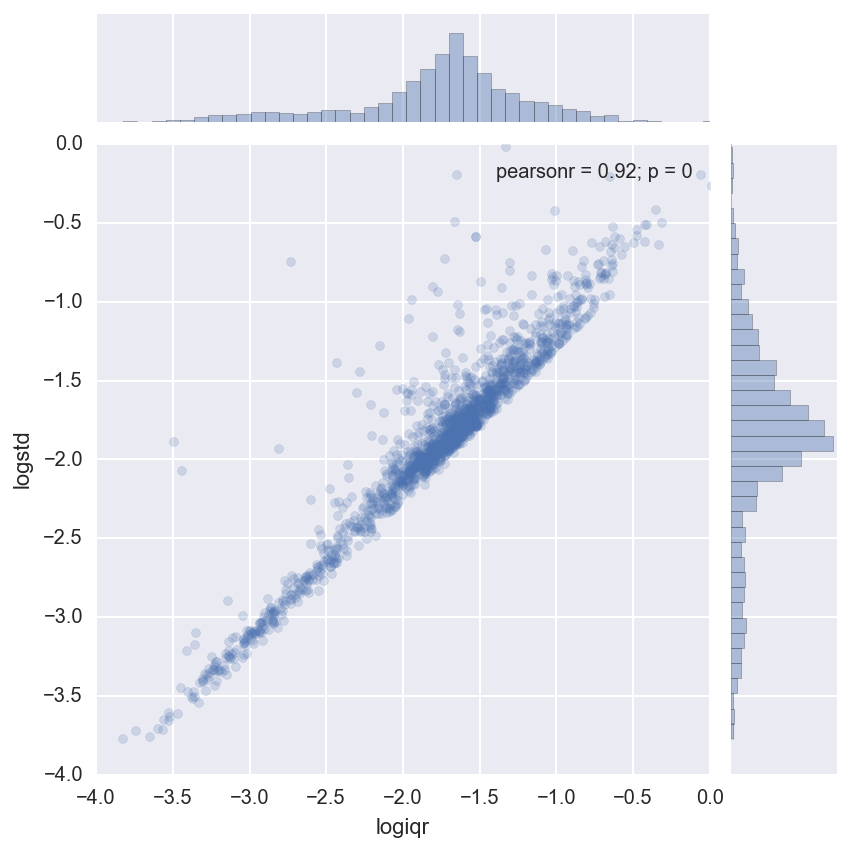

In [27]:
#tp = sns.jointplot(x="logiqr", y="logstd", alpha=0.2, kind='scatter',data=agg_data, xlim=(-4, 2));
sns.jointplot(x="logiqr", y="logstd", alpha=0.2, kind='scatter',data=cln_data, xlim=(-4, 0), ylim=(-4, 0));

The scatter of standard deviation above the interquartile range reflects sources with extra flicker noise beyond just secular sinusoidal variation.

In [28]:
ad = agg_data.dropna()
agg_data.shape, ad.shape

((1678, 12), (1658, 12))

I had to drop 20 lightcurves with `NaN` values.  Dunno what the deal is there.

In [29]:
#sns.distplot(ad['logiqr'].values, label='IQR')

### Search for sources in a specific range of variability.

In [30]:
gi = (ad.logiqr < - 1.1) & (ad.logiqr > -1.2) & (ad.logstd <-1.4)

//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


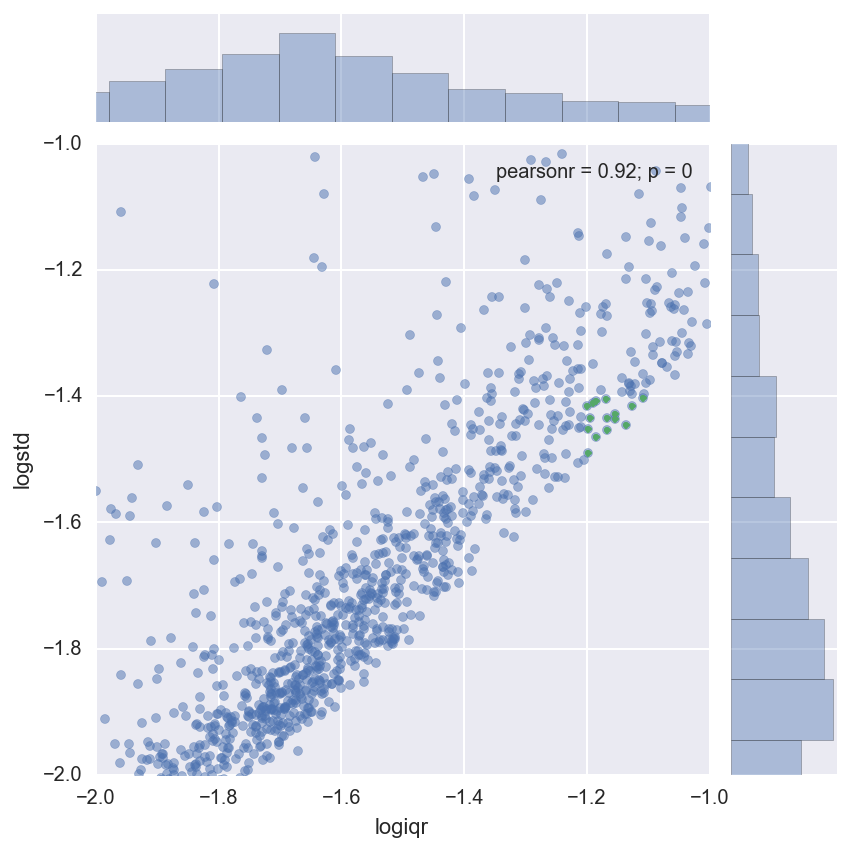

In [31]:
tp = sns.jointplot(x="logiqr", y="logstd", data=ad, xlim=(-2.0, -1.0), ylim=(-2.0, -1.0), alpha=0.5)
tp.ax_joint.plot(ad.logiqr[gi], ad.logstd[gi], '.', alpha=1.0)

In [32]:
print("There are {} sources that meet our above selection criterion".format(gi.sum()))

There are 15 sources that meet our above selection criterion


In [33]:
ad.EPIC_ID[gi].head()

226    203516237
271    203642381
313    203731383
559    203863067
639    203902911
Name: EPIC_ID, dtype: object

In [34]:
sns.set_context('paper', font_scale=1.3)
sns.set_style('ticks')

Spot-check the light curves by eye-- look for sinusoidal variations.

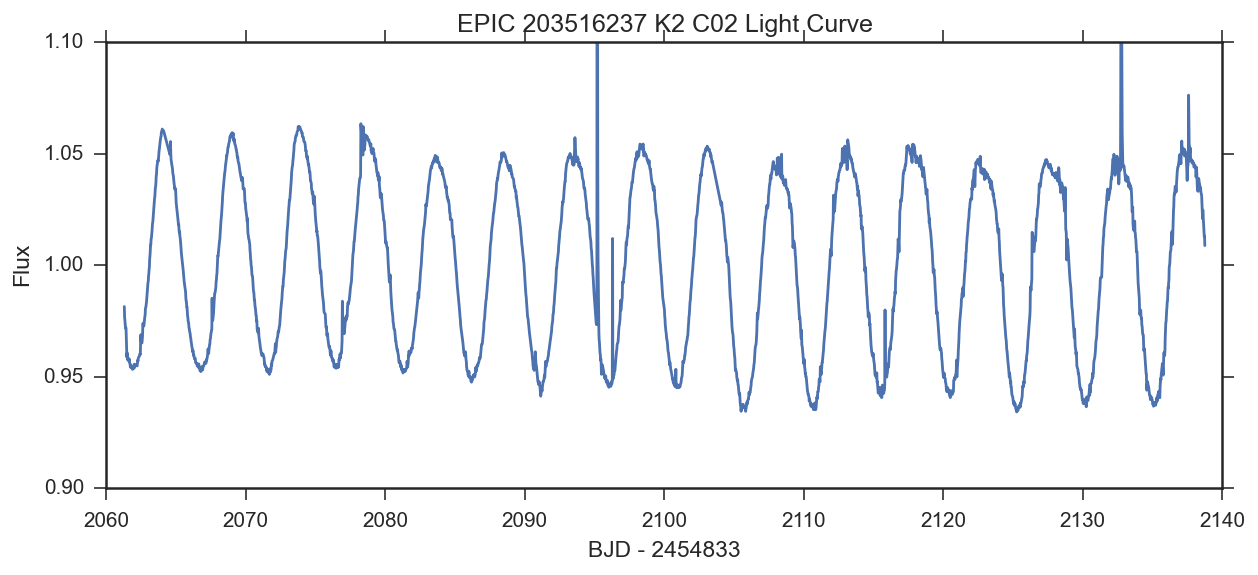

In [35]:
ii = 226

plt.figure(figsize=(10, 4))
file = ad.fname[ii]
raw_lc = pd.read_csv(file, index_col=False)

plt.plot(raw_lc['BJD - 2454833'], raw_lc[' Corrected Flux'])
plt.ylim(0.90, 1.1)
plt.title("EPIC {} K2 C02 Light Curve".format(ad.EPIC_ID[ii]))
plt.xlabel('BJD - 2454833')
plt.ylabel('Flux');

### Good candidates:  
226, 271, 313, 403, 474
### Good, but messy candidates:
421, 440

# Save the dataframe.

In [36]:
new_col_order = ['EPIC_ID','count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'logstd', 'logiqr','fname']

In [17]:
ad = ad[new_col_order]
ad.head(2)

,EPIC_ID,count,mean,std,min,25%,50%,75%,max,logstd,logiqr,fname
0,202515599,3273,0.989996,0.016853,0.951854,0.974293,0.997179,1.004053,1.100647,-1.773329,-1.526372,../data/hlsp_k2sff_k2_lightcurve_202515599-c02...
1,202521690,3252,1.004516,0.017012,0.961301,0.991919,1.004448,1.015255,1.150416,-1.769238,-1.631966,../data/hlsp_k2sff_k2_lightcurve_202521690-c02...


In [18]:
!mkdir ../analysis

mkdir: ../analysis: File exists


In [19]:
ad.to_csv('../analysis/K2C02_YSO_agg_data.csv', index=False)

# The end.